In [16]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import cv2
import os

import polyscope as ps
ps.init()

# Ray Tracing
This section aims to obtain ground thruth data from an animated scene simulated in blender
As a demonstration this script only looks at one frame of the sim however the functions and procedures for the full script are the same.

Loading Mesh and Camera Data

In [ ]:
def read_cam_data(path="../gt_RayCasting/camera_data6.json"):
    cams = []
    with open(path) as f:
        cam_data = json.load(f)

    # 180 around y
    rot_y_mat = np.array([
        [-1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)

    # Blender to O3D Coordinate Conversion Matrix - rotating -90 about x
    rot_mat = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]], dtype=np.float32)

    for i in range(4):
        cam_info = cam_data[i]
        
        # Get Matricies
        ex_mat = np.linalg.inv(np.array(cam_info["extrinsic_mat"], dtype=np.float32))

        ex_cam_rotated = rot_mat @ ex_mat
        ex_cam_rot_y = ex_cam_rotated @ rot_y_mat
        ex_world_rotated = np.linalg.inv(ex_cam_rot_y) #world to camera matrix - because thats what create_rays_pinhole_needs
        
        in_mat = np.array(cam_info["intrinsics"]["intrinsic_matrix"], dtype=np.float32)

        cam_tmp = {
            'ex_tensor' : o3d.core.Tensor(ex_world_rotated),
            'in_tensor' : o3d.core.Tensor(in_mat),
            'w' : cam_info["intrinsics"]["width"],
            'h' : cam_info["intrinsics"]["height"]
        }
        cams.append(cam_tmp)
    return cams

def load_mesh(path=os.path.abspath("/home/humense/arhma-capstone/simulation/ground_truth/mesh_dancer/frame_0001.ply")): # Temporary path
   
   mesh = o3d.io.read_triangle_mesh(path)
#    # Blender to O3D Coordinate Conversion Matrix - rotating -90 about x
#    rot_mat = np.array([
#        [1, 0, 0],
#        [0, 0, 1],
#        [0, -1, 0]], dtype=np.float32)

#    mesh_verts = np.asarray(mesh.vertices)
#    mesh_verts = (rot_mat @ mesh_verts.T).T
#    mesh.vertices = o3d.utility.Vector3dVector(mesh_verts)
   
   return mesh

cams_data = read_cam_data()
o3dmesh = load_mesh()

Set Up Polyscope Scene

In [7]:
def polyscope_cam_params(camera_data):
    ex_world = np.linalg.inv(camera_data['ex_tensor'].numpy())
    in_mat = camera_data['in_tensor'].numpy()
    w = camera_data['w']
    h = camera_data['h']

    # Intrinsics
    fy = in_mat[1, 1]
    fov_vertical_rad = 2 * math.atan(h / (2 * fy))
    fov_vertical_deg = math.degrees(fov_vertical_rad)
    aspect_ratio = w / h
    intrinsics = ps.CameraIntrinsics(fov_vertical_deg=fov_vertical_deg, aspect=aspect_ratio)

    # Extrinsics
    cam_pos = ex_world[:3, 3].tolist() # numpy array dosn't work for cam extrinsics in polyscope
    look_dir = (ex_world[:3, 2] / np.linalg.norm(ex_world[:3, 2])).tolist()
    up_dir = (ex_world[:3, 1] / np.linalg.norm(ex_world[:3, 1])).tolist()
    extrinsics = ps.CameraExtrinsics(root=cam_pos, look_dir=look_dir, up_dir=up_dir)

    print(f"cam_pos: {cam_pos}")
    print(f"look_dir: {look_dir}")
    print(f"up_dir: {up_dir}")

    return ps.CameraParameters(intrinsics, extrinsics)

for i, cam in enumerate(cams_data):
    print(f"Camera_{i+1} --------------------------")
    params = polyscope_cam_params(cam)
    cam = ps.register_camera_view(f"Camera {i+1}", params)

faces = np.asarray(o3dmesh.triangles)
vertices = np.asarray(o3dmesh.vertices)
ps_mesh = ps.register_surface_mesh("mesh", vertices, faces)

ps.show()
ps_mesh.remove()
#ps.remove_all_structures()

Camera_1 --------------------------
cam_pos: [5.0, 2.0, 2.066411074913045e-14]
look_dir: [-0.9805806875228882, -0.19611620903015137, -6.124738405333119e-08]
up_dir: [-0.19611620903015137, 0.9805806875228882, -7.872832696875776e-08]
Camera_2 --------------------------
cam_pos: [-5.0, 2.0, 2.066411074913045e-14]
look_dir: [0.9805806875228882, -0.19611620903015137, -6.124738405333119e-08]
up_dir: [0.19611620903015137, 0.9805806875228882, -7.872832696875776e-08]
Camera_3 --------------------------
cam_pos: [1.2223381689962197e-14, 2.0, -5.0]
look_dir: [1.025371574314704e-07, -0.19611608982086182, 0.9805806875228882]
up_dir: [-6.691534792935272e-08, 0.9805806875228882, 0.19611608982086182]
Camera_4 --------------------------
cam_pos: [-0.0, 2.0, 5.0]
look_dir: [-0.0, -0.19611608982086182, -0.9805806875228882]
up_dir: [-0.0, 0.9805806875228882, -0.19611608982086182]


Setting Up Scene for Ray Tracing with Open3D

ray casting complete!


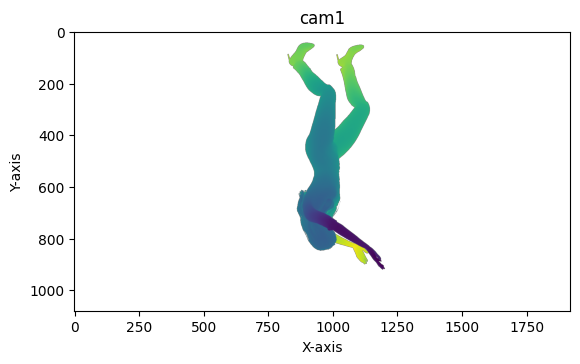

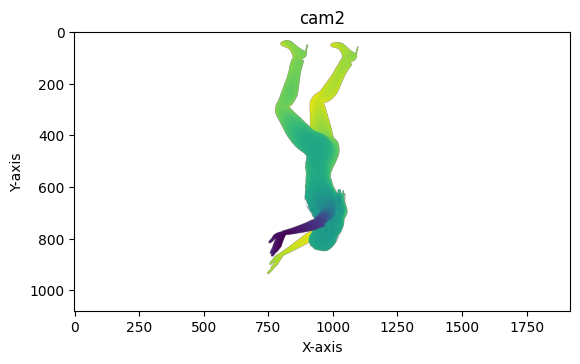

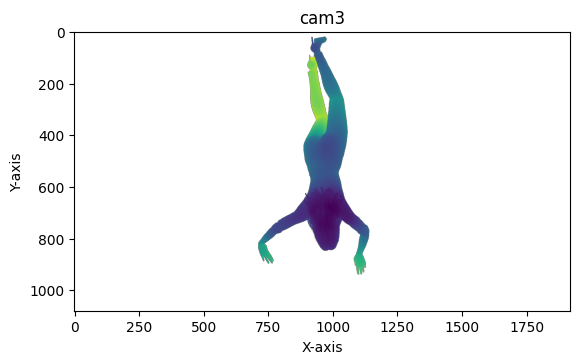

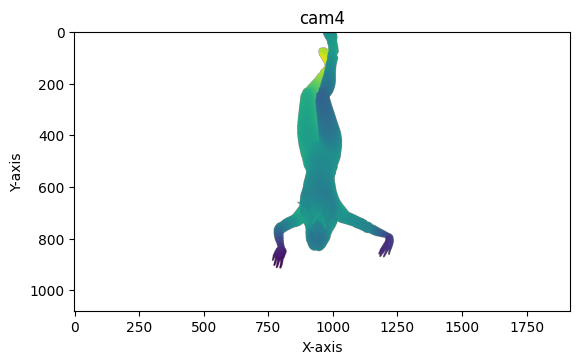

In [8]:
def ray_cast(scene, cams):

    ans = []
    
    for cam in cams:
        rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
            intrinsic_matrix=cam['in_tensor'],
            extrinsic_matrix=cam['ex_tensor'],
            width_px=cam["w"],
            height_px=cam["h"]
        )
        
        cast_ans = scene.cast_rays(rays)
        ans.append(cast_ans)
    
    return ans

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(o3dmesh))
cast_ans = ray_cast(scene, cams_data)
print("ray casting complete!")

for i, a in enumerate(cast_ans):
            # Display Result - for debugging ------------------
            plt.imshow(a['t_hit'].numpy())
            plt.title(f"cam{i+1}")
            plt.xlabel("X-axis")
            plt.ylabel("Y-axis")
            plt.show()


Saving the Ground Truth - Do not run unless happy with the ray_tracing result

In [9]:
def build_dict(ans, mesh):
    # should be based off the camera data but since its known its fine for now
    width_px = 1920
    height_px = 1080

    # Get triangle and vertex data from the passed object_mesh (which is already transformed)
    faces = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    triangle_vertices = vertices[faces]

    primitive_ids = ans['primitive_ids'].numpy().reshape((height_px, width_px))
    primitive_uvs = ans['primitive_uvs'].numpy().reshape((height_px, width_px , 2))

    camera_hit_list = []
    count = 0
    for y in range(height_px):
        for x in range(width_px):
            tri_id = primitive_ids[y,x]

            if tri_id == o3d.t.geometry.RaycastingScene.INVALID_ID:
                count += 1
                continue  # Skip rays that didn't hit anything

            u, v = primitive_uvs[y, x]
            v0, v1, v2 = triangle_vertices[tri_id]
            hit_point = (1 - u - v) * v0 + u * v1 + v * v2

            dv1 = float(np.linalg.norm(hit_point - v0))
            dv2 = float(np.linalg.norm(hit_point - v1))
            dv3 = float(np.linalg.norm(hit_point - v2))

            # add data to list
            camera_hit_list.append({
                "pixel": [x, y],
                "triangle_id": int(tri_id),
                "hit": hit_point.tolist(),
                "dv1": dv1,
                "dv2": dv2,
                "dv3": dv3
            })

    return camera_hit_list

mesh_folder = os.path.abspath("gt_data")
for i, a in enumerate(cast_ans):
    data = build_dict(a, o3dmesh)
    cam_path = os.path.join(mesh_folder, f"Camera_{i+1}")
    os.makedirs(cam_path, exist_ok=True)
    
    file_path = os.path.join(cam_path, "frame_0001.json")
    with open(file_path, "w") as f: 
        json.dump(data, f, indent=2)

    print(f"Ground Truth for Camera_{i+1} added")

Ground Truth for Camera_1 added
Ground Truth for Camera_2 added
Ground Truth for Camera_3 added
Ground Truth for Camera_4 added


Read and Plot from .json

In [10]:
def get_point_clouds(cams):
    all_points = []
    all_directions = []

    for i in range(4):
        with open(f'gt_data/Camera_{i+1}/frame_0001.json', 'r') as f:
            camera_hit_list = json.load(f)

        # Extract just the hit points
        hit_points = np.array([entry['hit'] for entry in camera_hit_list if entry['hit'] is not None], dtype=np.float32)

        cam_origin = np.linalg.inv(cams[i]['ex_tensor'].numpy())[:3,3]
        direction = hit_points - cam_origin

        # Convert to Point Cloud
        # pcd = o3d.geometry.PointCloud()
        # pcd.points = o3d.utility.Vector3dVector(hit_points)

        all_points.append(hit_points)
        all_directions.append(direction)
        print("pt cld added")

    return all_points, all_directions 

hit_pts, directions = get_point_clouds(cams_data)
pcds = []
for i in range(len(hit_pts)):
    pcd = ps.register_point_cloud(f"Cam{i+1} hit points", hit_pts[i])
    #pcd.add_vector_quantity(f"Cam{i+1} vectors", directions[i], enabled=True)
    pcds.append(pcd)

ps.show()
ps.remove_all_structures() # clear the whole scene
# for pcd in pcds:
#     pcd.remove()

pt cld added
pt cld added
pt cld added
pt cld added


# Depth Renders to Point Cloud
This section aims to convert depth images rendered from the blender simulation into a point cloud
(last remaining section to do) 

In [21]:
def load_normalized_depth(path):
    max_depth = 5.0
    depth = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    depth = depth[:, :, 0] 
    depth = (depth / 255.0) * max_depth
    return o3d.geometry.Image(depth)

def img_to_pcd(cams, dir='../renders_for_test'):
    
    pcds = []
    for i, cam in enumerate(cams):
        extrinsics = np.linalg.inv(cam['ex_tensor'].numpy())
        extrinsics = extrinsics.astype(np.float64)

        intrinsics = cam['in_tensor'].numpy()
        intrinsics = intrinsics.astype(np.float64)

        cam_intrinsics = o3d.camera.PinholeCameraIntrinsic(
            cam['w'], cam['h'], intrinsics
        )

        depth_img_path = os.path.join(dir, f"renders/Camera_{i+1}/depth_png/depth_norm_0001.png")
        rgb_img_path = os.path.join(dir, f"renders/Camera_{i+1}/rgb/rgb_0001.png")
            
        depth_img =load_normalized_depth(depth_img_path) # using opencv
        #depth_img = o3d.io.read_image(depth_img_path)
        rgb_img = o3d.io.read_image(rgb_img_path)
        
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_img, depth_img, 1.0, 5.0, False) 
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, cam_intrinsics, extrinsics)
        pcds.append(pcd)
    
        frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2).transform(extrinsics)
        o3d.visualization.draw_geometries([frame, pcd])

    return pcds

img_pcds = img_to_pcd(cams_data)

depth_pcds = []
for i, pcd in enumerate(img_pcds):
    downsampled = pcd.voxel_down_sample(voxel_size=0.01)
    points = np.asarray(downsampled.points) #downsampled.points)
    if points.size > 0:
        depth_pcd = ps.register_point_cloud(f"Camera {i+1} points", points)
        depth_pcds.append(depth_pcd)

ps.show()
for p in depth_pcds:
    p.remove()

libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
libpng warning: eXIf: invalid
